In [81]:
import time
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, plot_confusion_matrix
import plotly.graph_objects as go
df = pd.read_csv('./dataset/Apply_Rate_2019.csv').drop(['class_id'], axis=1)
df.drop_duplicates(inplace=True)
df.isnull().sum()

title_proximity_tfidf          193541
description_proximity_tfidf    193541
main_query_tfidf                    0
query_jl_score                      0
query_title_score                   0
city_match                     241083
job_age_days                        0
apply                               0
search_date_pacific                 0
dtype: int64

In [82]:
# drop duplicate
df.drop_duplicates(inplace=True)

fig = go.Figure([go.Bar(x=df['apply'].unique(), y=df['apply'].value_counts())])
fig.update_layout(xaxis_type='category', title_text='Apply frequency', title_x=0.5)
fig.show()  # imbalanced

In [83]:
# start fking preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import random
import math

# fill missing values by MICE, then change city_match back to 0/1
# because directly assign 0 to city_match will worsen the result.
df.iloc[:,:2] = IterativeImputer().fit_transform(df.iloc[:,:2])
df.iloc[:,5:6] = IterativeImputer().fit_transform(df.iloc[:,5:6])
df['city_match'] = df['city_match'].round()

df.describe()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply
count,1.086406e+06,1.086406e+06,1.086406e+06,1.086406e+06,1.086406e+06,1.086406e+06,1.086406e+06,1.086406e+06
mean,6.020506e+00,9.808819e-02,1.874158e+00,1.713798e-02,3.616302e-02,6.544027e-01,1.052224e+01,9.049379e-02
std,8.896574e+00,2.596325e-01,2.254636e+00,1.246974e-02,4.941218e-02,4.755628e-01,1.783499e+01,2.868880e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-06,9.998021e-07,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,1.043009e-02,1.229762e-02,0.000000e+00,2.000000e+00,0.000000e+00
50%,0.000000e+00,2.799273e-02,7.844908e-01,1.562717e-02,2.041954e-02,1.000000e+00,6.000000e+00,0.000000e+00
75%,7.979742e+00,9.808819e-02,3.570944e+00,2.069120e-02,3.824712e-02,1.000000e+00,1.500000e+01,0.000000e+00
max,9.351672e+01,7.301161e+00,1.774189e+01,2.556893e-01,1.294088e+00,1.000000e+00,1.340000e+03,1.000000e+00


In [84]:
print('number of NaN in title_proximity_tfidf:',len(df[df['title_proximity_tfidf'].isnull()]))
print('number of NaN in description_proximity_tfidf:',len(df[df['description_proximity_tfidf'].isnull()]))
print('number of NaN in city_match:',len(df[df['city_match'].isnull()]))

number of NaN in title_proximity_tfidf: 0
number of NaN in description_proximity_tfidf: 0
number of NaN in city_match: 0


In [85]:
df.head()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply,search_date_pacific
0,0.000000,0.000000,0.000000,0.004824,0.006628,0.0,5.0,0,2018-01-21
1,11.874042,0.043637,2.527080,0.011935,0.011208,0.0,5.0,0,2018-01-21
2,11.874042,0.043637,2.527080,0.011935,0.011208,0.0,5.0,1,2018-01-21
3,0.000000,0.000000,3.695809,0.013046,0.033340,0.0,5.0,0,2018-01-23
4,6.020506,0.098088,7.868900,0.008065,0.008772,0.0,7.0,0,2018-01-24


In [86]:
test_x = df[df['search_date_pacific']=='2018-01-27'].drop(['search_date_pacific'], axis=1)
x = len(test_x)
train_x = df[df['search_date_pacific']!='2018-01-27'].drop(['search_date_pacific'], axis=1)
y = len(train_x)
print('before separated:',len(df))
print('after separated:',x+y)

before separated: 1086406
after separated: 1086406


In [87]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
#from imblearn.over_sampling import SMOTE

# train_x, test_x = train_test_split(df, test_size=0.2, random_state=4211)
train_y = train_x.pop('apply')
test_y = test_x.pop('apply')

# Normalisation using the sklearn StandardScaler. Set the mean to 0 and sd to 1.
transform_columns = ['title_proximity_tfidf', 'description_proximity_tfidf', 'main_query_tfidf', 'query_jl_score', 'query_title_score', 'job_age_days']
ct = ColumnTransformer(
        remainder='passthrough',
        transformers=[('std', StandardScaler(), transform_columns)])
train_x = ct.fit_transform(train_x)
test_x = ct.fit_transform(test_x)

# after ColumnTransformm, city_match is at the ENDDDDDDD of the dataframe, this took me hours to figure out :)
x_columns = ['title_proximity_tfidf', 'description_proximity_tfidf', 'main_query_tfidf', 'query_jl_score', 'query_title_score', 'job_age_days', 'city_match']
train_x = pd.DataFrame(train_x, columns=x_columns)
test_x = pd.DataFrame(test_x, columns=x_columns)

# undersampling to reduce imbalance
#train_x, train_y = SMOTE(sampling_strategy=0.2, random_state=0).fit_resample(train_x, train_y)  # not much different
train_x, train_y = RandomUnderSampler(random_state=0).fit_resample(train_x, train_y)

train_x.describe()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,job_age_days,city_match
count,177208.000000,177208.000000,177208.000000,177208.000000,177208.000000,177208.000000,177208.000000
mean,0.062136,-0.004198,0.045748,0.082637,0.089707,-0.022920,0.659908
std,1.050864,1.011606,1.008600,1.100211,1.112646,0.990729,0.473741
min,-0.676992,-0.378304,-0.830372,-1.380463,-0.732116,-0.602250,0.000000
25%,-0.676992,-0.378304,-0.830372,-0.511098,-0.468736,-0.488244,0.000000
50%,-0.676992,-0.274632,-0.375627,-0.101385,-0.283004,-0.260232,1.000000
75%,0.523936,-0.000272,0.840587,0.363792,0.139185,0.195792,1.000000
max,7.682173,24.914928,7.031150,19.334764,24.926655,71.221484,1.000000


In [88]:
train_x.head()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,job_age_days,city_match
0,-0.676992,-0.378304,0.043339,-0.688836,-0.562773,-0.602250,0.0
1,1.606913,0.748207,0.759776,0.489567,-0.268045,7.663180,0.0
2,2.470372,3.855313,1.458380,1.590819,-0.195103,-0.545247,1.0
3,-0.676992,-0.076774,-0.830372,-0.676733,-0.509387,-0.545247,0.0
4,0.000445,-0.000272,-0.826476,-0.337936,-0.416778,-0.089223,0.0


In [89]:
def report(clf):
    pred_y = clf.predict(test_x)

    print(classification_report(test_y, pred_y))
    disp = plot_confusion_matrix(clf, test_x, test_y)
    disp.figure_.suptitle("Confusion Matrix")

46.366907835006714
              precision    recall  f1-score   support

           0       0.93      0.63      0.75     96347
           1       0.12      0.52      0.20      9709

    accuracy                           0.62    106056
   macro avg       0.53      0.57      0.47    106056
weighted avg       0.86      0.62      0.70    106056



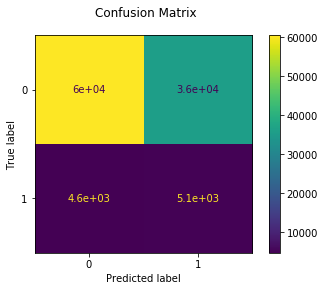

In [90]:
mlp = MLPClassifier(hidden_layer_sizes=(80, 60, ), learning_rate='adaptive', 
                    activation='relu',early_stopping=True, random_state=4211)

start = time.time()
mlp.fit(train_x, train_y)
print(time.time()-start)
report(mlp) # city_match not normalised, undersampling only

35.63493752479553
              precision    recall  f1-score   support

           0       0.92      0.37      0.53     96347
           1       0.10      0.66      0.17      9709

    accuracy                           0.40    106056
   macro avg       0.51      0.52      0.35    106056
weighted avg       0.84      0.40      0.49    106056



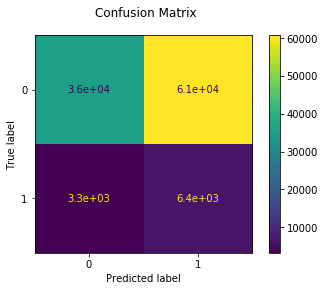

In [91]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 60, 30), learning_rate='invscaling', 
                    activation='identity',solver='sgd',early_stopping=True, random_state=4211)

start = time.time()
mlp.fit(train_x, train_y)
print(time.time()-start)
report(mlp) # city_match not normalised, undersampling only

In [92]:
# # report the result
# def report2(results, n_top=5):
#     for i in range(1, n_top + 1):
#         candidates = np.flatnonzero(results['rank_test_score'] == i)
#         for candidate in candidates:
#             print("Model with rank: {0}".format(i))
#             print("Mean validation score: {0:.5f} (sd: {1:.5f})"
#                   .format(results['mean_test_score'][candidate],
#                           results['std_test_score'][candidate]))
#             print("Hyperparameter setting: {0}".format(results['params'][candidate]))
#             print("")

In [93]:
# # model
# grid_search = {'hidden_layer_sizes': [(50, ), (100, ), (150, )],
#                'activation':['relu','identity','logistic','tanh'],
#                'solver':['lbfgs','sgd','adam'],
#                 'learning_rate': ['constant', 'adaptive'],
#                 'learning_rate_init': [0.01, 0.5],
#                 'random_state': [4211],
#                 'verbose':[2],'early_stopping':[True]
#                 }
# mlp = MLPClassifier()
# grid_search = GridSearchCV(mlp, grid_search, n_jobs=-1, cv=5, verbose=3)
# grid_search.fit(train_x, train_y)
# report2(grid_search.cv_results_, 3)

In [ ]:
from sklearn.svm import LinearSVC, SVC
clf = SVC()

start = time.time()
clf.fit(train_x, train_y)
print(time.time()-start)
report(clf)  # true negative more but true positive less than above nn, lul

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.5min finished
D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



              precision    recall  f1-score   support

           0       0.92      0.70      0.79     96347
           1       0.12      0.42      0.19      9709

    accuracy                           0.67    106056
   macro avg       0.52      0.56      0.49    106056
weighted avg       0.85      0.67      0.74    106056



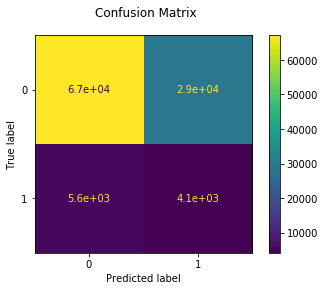

In [95]:
from sklearn.model_selection import GridSearchCV  # this thing cpu intensive.
tuned_parameters = {'C':np.arange(0.01,100,50)}

clf = GridSearchCV(LinearSVC(), tuned_parameters, n_jobs=-1, verbose=2)
clf.fit(train_x, train_y)
report(clf)  # no much difference